# Fig 10: Changing variability and its impact on OLR emergence

Originally developed in fig10_OLRvariabilitychange.ipynb

### Do imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    np, xr, plt, sns, os, 
    datetime, gridspec, 
    Iterable, cmaps, glob, copy,
    dask,pd
    )

from functions import (
    add_weights,
    to_png, stats, fix_cesm_time
    )

from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

### Load pre-processed timeseries

Model output.

In [2]:
tseries_savedir = '/glade/u/home/jonahshaw/w/LENS/CESM1-LE/ArcticTimeSeries/'

cesm1_pic_ds = xr.open_dataset('%s/CESM1_PIControl_ArcticTimeSeries.nc' % tseries_savedir)
cesm1_ensresponse_ds = xr.open_dataset('%s/CESM1_RCP8.5Members_ArcticTimeSeries.nc' % tseries_savedir)

In [3]:
cesm1_ensresponse_olr = cesm1_ensresponse_ds['FLUT']
cesm1_pic_olr = cesm1_pic_ds['FLUT']

### New better plot idea

__What I need to show is the time-dependence (I want to vary the trend length but keep the start year at 2001). I can do this by plotting the difference between the standard deviation of the 40 ensemble members and a bootstrapped mean standard deviation of 40 unforced trends as each year is added. I can show that the standard deviation of the forced trends is changing by constructing confidence intervals on the unforced standard deviation using bootstrapping.__

Steps:   
1. Calculate the standard deviation of forced trends starting in 2001 and extending to 2080.  
2. Bootstrap standard deviations of unforced trends with length ranging from 2 to 80 years with an ensemble size of 40.  
3. Compute the mean standard deviation for each duration and a 95% confidence interval on that mean.  
4. Plot and compare!  



1. Calculate the standard deviation of forced trends starting in 2001 and extending to 2080.  


In [4]:
# need a wrapper function because you can't groupby multiple dimensions
def gettrends_wrapper(dataarray,dim):
    
    dataarray[dim] = dataarray['time.year']

    return dataarray.groupby('ens').map(xr.DataArray.polyfit,dim=dim,deg=1)['polyfit_coefficients'].sel(degree=1)

In [5]:
def gettrends_PIC_wrapper(dataarray,dim):
    
    dataarray[dim] = dataarray['time.year']

    return dataarray.polyfit(dim=dim,deg=1)['polyfit_coefficients'].sel(degree=1)

In [6]:
%%time

slopes_by_dur = []

endyears = np.arange(2002,2081)

for _endyr in endyears:
    
    tsel = cesm1_ensresponse_olr.sel(time=slice(None,str(_endyr)))
    
    slopes_endyr = tsel.groupby('time.month').map(gettrends_wrapper,dim='time').drop('degree')
    
    slopes_endyr['endyear'] = _endyr
    slopes_endyr['duration'] = _endyr - 2000
    
    slopes_by_dur.append(slopes_endyr)
    
    # if _endyr == 2005:
    #     break
        
forced_olrslopes_monthly = xr.concat(slopes_by_dur,dim='endyear')

CPU times: user 54.5 s, sys: 101 ms, total: 54.6 s
Wall time: 56.9 s


forced_olrslopes_monthly

2. Bootstrap standard deviations of unforced trends with length ranging from 2 to 80 years with an ensemble size of 40.  

2a. Pre-compute trends for different start years. This will be slow and if I can get dask working this is a good place to do it.

In [7]:
def get_unforced_trends_allstartyears(data,duration):
    '''
    Calculate trends of a passed duration from a large ensemble. Iterate over every possible start year.
    Do monthly.
    '''
    startyears = np.arange(400,2202-duration,1)

    trend_array = np.nan * np.ones((12,len(startyears))) # initialize empty array

    for i,startyear in enumerate(startyears):

        _startyr = str(startyear)
        if len(_startyr)==3:
            _startyr = '0' + _startyr

        _endyr = str(startyear+duration-1)
        if len(_endyr)==3:
            _endyr = '0' + _endyr

        olr_tsel = data.sel(time=slice(_startyr,_endyr)) # index differently here because the dates are different

        _monthly_trends = olr_tsel.groupby('time.month').map(gettrends_PIC_wrapper,dim='time')

        trend_array[:,i] = _monthly_trends

        # break

    # shift the data to an xarray object so future operations do not require iteration
    unforced_trends_da = xr.DataArray(
        data=trend_array,
        dims=['month','startyear'],
        coords=dict(
            month=np.arange(1,13),
            startyear=(startyears),
        )
    )
    unforced_trends_da['duration'] = duration # add this coordinate so that we can concatentate along it later
    
    return unforced_trends_da

In [8]:
if os.path.exists('unforced_OLR_trends_month_duration_startyear.nc'):

    trends_allstartyear_allduration = xr.open_dataarray('unforced_OLR_trends_month_duration_startyear.nc')
    
else:
    print('It will take a while to calculate this by itself. Script below is commented')
    
## DO NOT DELETE THIS JONAH!!
    
# # ideal for dasking later

# trends_allstartyear_allduration_list = []

# durations = np.arange(2,81,)
# for duration in durations:
#     test_trends = get_unforced_trends_allstartyears(cesm1_pic_olr,duration=duration)
    
#     trends_allstartyear_allduration_list.append(test_trends)    

# trends_allstartyear_allduration = xr.concat(trends_allstartyear_allduration_list,dim='duration')

# trends_allstartyear_allduration.to_netcdf('unforced_OLR_trends_month_duration_startyear.nc')

Do not delete this!!

In [ ]:
# %%time

# # ideal for dasking later

# trends_allstartyear_allduration_list = []

# durations = np.arange(2,81,)
# for duration in durations:
#     test_trends = get_unforced_trends_allstartyears(cesm1_pic_olr,duration=duration)
    
#     trends_allstartyear_allduration_list.append(test_trends)    

# trends_allstartyear_allduration = xr.concat(trends_allstartyear_allduration_list,dim='duration')

In [ ]:
# trends_allstartyear_allduration.to_netcdf('unforced_OLR_trends_month_duration_startyear.nc')

Use bootstrapping to compute confidence intervals for each trend duration and month.

In [40]:
def bootstrap_monthly(data,N_ens,n_bootstraps=1000):

    newdata_array = np.nan * np.ones((12,n_bootstraps)) # initialize empty array
    # _bounds_dict_bstrap = {} # empty dictionary to store objects in

    gen = np.random.Generator(np.random.PCG64()) # generator object for sampling a n-D array

    for i in range(n_bootstraps): # bootstrap, calculating percentiles
        # resample along the ensemble dimension (axis 1)
        resample_slopes = gen.choice(data, size=N_ens, replace=True,axis=1)

        slope_stddev = resample_slopes.std(axis=1)
        newdata_array[:,i] = slope_stddev
        
    return newdata_array

In [149]:
%%time

# resample the trends from the PI-Control using bootstrapping to estimate a confidence interval on the standard deviation
n_bootstraps = 1000

N_ens = 40
durations = np.arange(2,80)

stddevs_all_durations_list = []

for duration in durations:
    print(str(duration)+' ',end='')

    trends_allstartyear_durationsubset = trends_allstartyear_allduration.sel(duration=duration).dropna(dim='startyear')
    bootstrapped_trend_stddevs = bootstrap_monthly(trends_allstartyear_durationsubset,N_ens=N_ens,n_bootstraps=n_bootstraps)
    
    # shift the data to an xarray object so future operations do not require iteration
    unforced_trends_std_da = xr.DataArray(
        data=bootstrapped_trend_stddevs,
        dims=['month','bootstrap'],
        coords=dict(
            month=np.arange(1,13),
            bootstrap=(np.arange(n_bootstraps)),
        )
    )
    unforced_trends_std_da['endyear'] = 2000+duration # add this coordinate so that we can concatentate along it later
    stddevs_all_durations_list.append(unforced_trends_std_da)
    
stddevs_all_durations = xr.concat(stddevs_all_durations_list,dim='endyear')


2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 CPU times: user 18.4 s, sys: 4.99 ms, total: 18.4 s
Wall time: 18.8 s


Compute a confidence interval on the standard deviation of trends of various lengths/months in an unforced climate.

In [80]:
def percentile_wrapper(a,q,**kwargs):
    
    return xr.DataArray(np.percentile(a=a,q=q,**kwargs))

def groupby_wrapper(data,groupby_dim,function,**kwargs):
    
    return data.groupby(groupby_dim).map(function,**kwargs)

In [206]:
def multidim_groupby_map(data,groupby_dims,ffunc,**func_kwargs):
    print(groupby_dims)
    print(len(groupby_dims))
    print(len(groupby_dims)==1)
    if len(groupby_dims)==1:
        print('yes')
        out = data.groupby(groupby_dims.pop()).map(ffunc,**func_kwargs)
        print(out)
        return data.groupby(groupby_dims.pop()).map(ffunc,**func_kwargs)
    else:
        return data.groupby(groupby_dims.pop()).map(multidim_groupby_map,groupby_dims=groupby_dims,ffunc=ffunc,**func_kwargs)

In [207]:
multidim_groupby_map(stddevs_all_durations,groupby_dims=['month','endyear'],ffunc=percentile_wrapper,q=2.5)

['month', 'endyear']
2
False
['month']
1
True
yes
<xarray.DataArray (month: 12)>
array([3.81823758, 3.9217607 , 3.60948992, 3.3312958 , 2.38342846,
       1.72339393, 1.55230223, 1.27642605, 1.52307387, 2.41678192,
       3.44770932, 3.79282538])
Coordinates:
    endyear  int64 2002
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12


IndexError: pop from empty list

In [177]:
listt = ['hi','bob','op']

In [179]:
listt.pop()

'op'

In [180]:
listt

['hi', 'bob']

Pass an arbitrary number of dimension arguments to the groupby_wrapper and then call it on itself until only a single argument remains.

In [151]:
mean_unforced_trendstddev = stddevs_all_durations.mean(dim='bootstrap')

low_unforced_trendstddev  = stddevs_all_durations.groupby('month').map(groupby_wrapper,groupby_dim='endyear',function=percentile_wrapper,q=2.5)
high_unforced_trendstddev = stddevs_all_durations.groupby('month').map(groupby_wrapper,groupby_dim='endyear',function=percentile_wrapper,q=97.5)

#### Plot 

Text(0.5, 0.08, 'Trend Start Year')

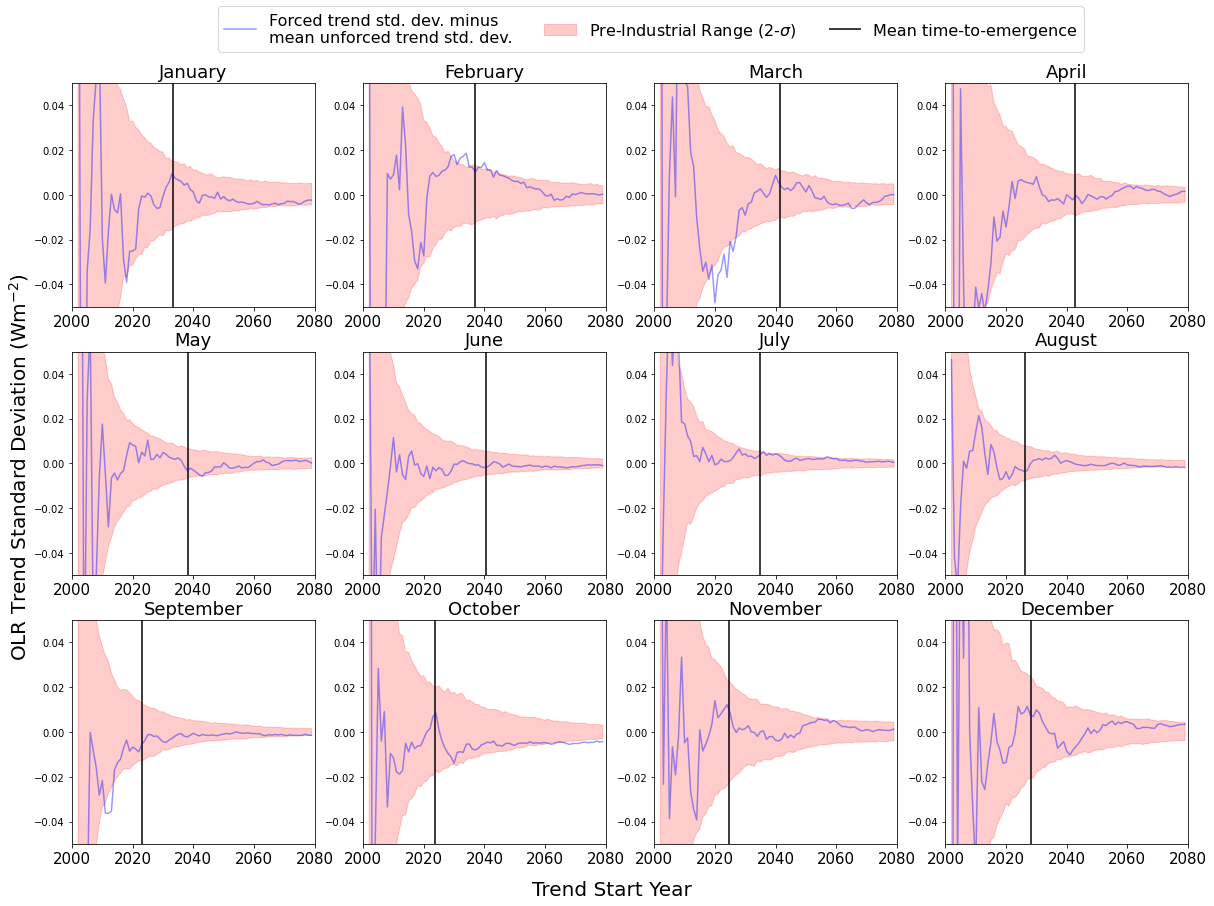

In [174]:
fig,axs = plt.subplots(3,4,figsize=(20,14))
axs = axs.flat

month_list = ['January','February','March','April','May','June','July','August','September','October','November','December']
emerge_years = [32.225, 35.975, 40.425, 41.7, 37.375, 39.475, 33.95, 25.175, 21.925, 22.6, 23.55, 27.325]

forced_olrslopes_monthly_std = forced_olrslopes_monthly.std(dim='ens')
forced_olrslopes_monthly_std_cut = forced_olrslopes_monthly_std.sel(endyear=slice(None,2079)).drop('duration')

trendstd_error = forced_olrslopes_monthly_std_cut - mean_unforced_trendstddev
trendstd_lowbnd = low_unforced_trendstddev - mean_unforced_trendstddev
trendstd_highbnd = high_unforced_trendstddev - mean_unforced_trendstddev

for _forced_err,_low_err,_high_err,_ax,_month,_emerge_year in zip(trendstd_error.transpose(),
                                                                   trendstd_lowbnd.transpose(),
                                                                   trendstd_highbnd.transpose(),
                                                                   axs,month_list,emerge_years
                                                                 ):

    # _ax.plot(_forced['endyear'],_forced,alpha=0.2,color='black',label='OLR Trend Std. Dev.')#,label='%.4f $\pm$ %.4f' % (slope,2*stderr))
    _ax.plot(np.arange(2002,2080),_forced_err,alpha=0.4,color='blue',label='Forced trend std. dev. minus \nmean unforced trend std. dev.')#,label='%.4f $\pm$ %.4f' % (slope,2*stderr))
    
    _ax.fill_between(np.arange(2002,2080),y1=_low_err,y2=_high_err,alpha=0.2,color='red',label='Pre-Industrial Range (2-$\sigma$)')
    
    # _ax.fill_between(x=_mon['endyear'],y1=pi_lower,y2=pi_upper,alpha=0.4,label='Pre-Industrial Range (2-$\sigma$)')
    
    ymin,ymax = _ax.get_ylim()
    
    _ax.vlines(x=2001+_emerge_year,ymin=ymin,ymax=ymax,color='black',label='Mean time-to-emergence')
    
    title = _month
    
    _ax.set_title(title,fontsize=18)
    _ax.set_ylim(ymin,ymax)
    _ax.set_ylim(-0.05,0.05)
    # _ax.set_ylim(1,5)
    _ax.set_xticks(np.arange(2000,2081,20))#,fontsize=14)
    _ax.set_xticklabels(np.arange(2000,2081,20),fontsize=15)
    _ax.set_xlim(2000,2080)
    
axs[0].legend(fontsize=16,loc=(0.6,1.14),ncol=3)
    
fig.text(x=0.08,y=0.5,s='OLR Trend Standard Deviation (Wm$^{-2}$)',rotation=90,fontsize=20,va='center')
fig.text(x=0.5,y=0.08,s='Trend Start Year',rotation=0,fontsize=20,va='center',ha='center')

Text(0.5, 0.08, 'Trend Start Year')

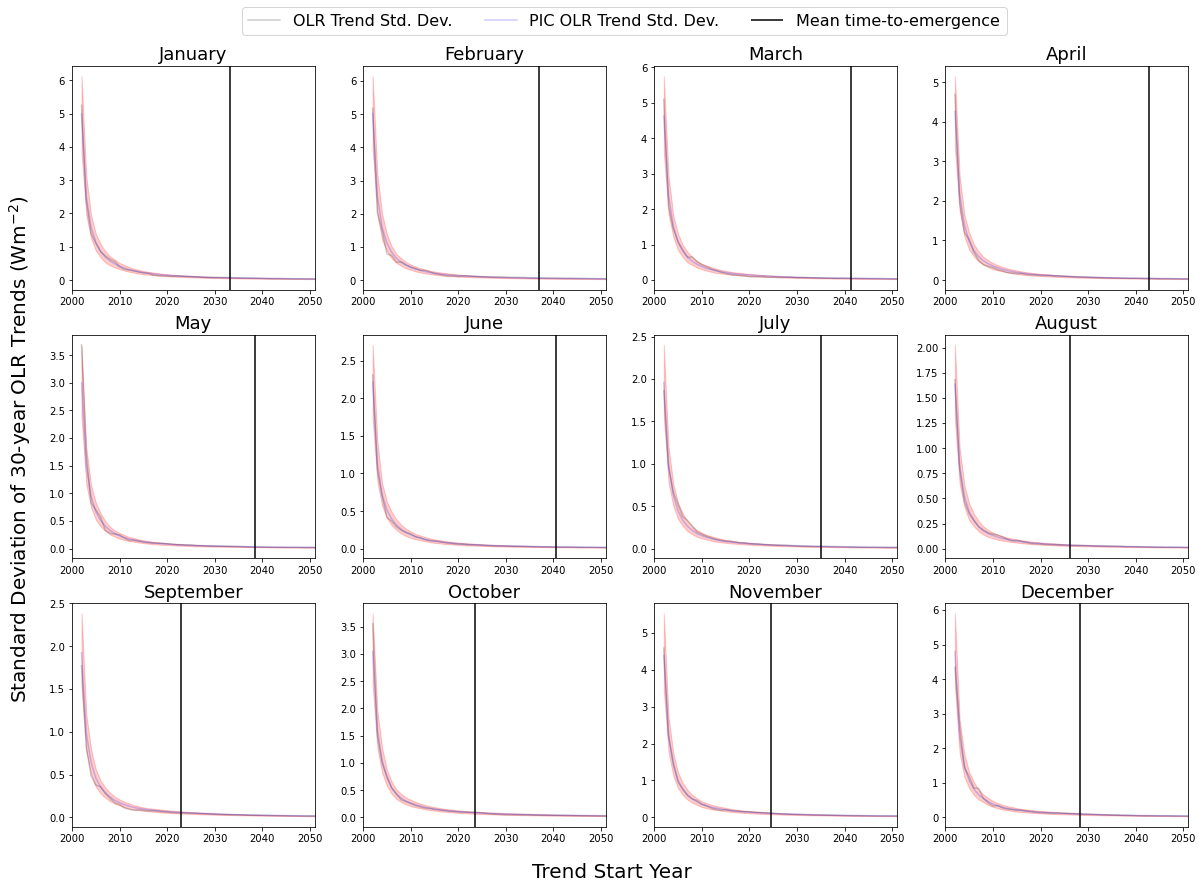

In [175]:
fig,axs = plt.subplots(3,4,figsize=(20,14))
axs = axs.flat

month_list = ['January','February','March','April','May','June','July','August','September','October','November','December']
emerge_years = [32.225, 35.975, 40.425, 41.7, 37.375, 39.475, 33.95, 25.175, 21.925, 22.6, 23.55, 27.325]

forced_olrslopes_monthly_std = forced_olrslopes_monthly.std(dim='ens')

for _forced,_unforced_mean,_unforced_low,_unforced_high,_ax,_month,_emerge_year in zip(forced_olrslopes_monthly_std.transpose(),
                                                                                       mean_unforced_trendstddev.transpose(),
                                                                                       low_unforced_trendstddev.transpose(),
                                                                                       high_unforced_trendstddev.transpose(),
                               axs,month_list,emerge_years
                                                              # lower_percentile,upper_percentile,
                                                              # axs,month_list,emerge_years,
                                                             ):

    _ax.plot(_forced['endyear'],_forced,alpha=0.2,color='black',label='OLR Trend Std. Dev.')#,label='%.4f $\pm$ %.4f' % (slope,2*stderr))
    _ax.plot(np.arange(2002,2080),_unforced_mean,alpha=0.2,color='blue',label='PIC OLR Trend Std. Dev.')#,label='%.4f $\pm$ %.4f' % (slope,2*stderr))
    
    _ax.fill_between(np.arange(2002,2080),y1=_unforced_low,y2=_unforced_high,alpha=0.2,color='red')
        
    ymin,ymax = _ax.get_ylim()
    
    _ax.vlines(x=2001+_emerge_year,ymin=ymin,ymax=ymax,color='black',label='Mean time-to-emergence')
    
    title = _month
    
    _ax.set_title(title,fontsize=18)
    _ax.set_ylim(ymin,ymax)
    # _ax.set_ylim(1,5)
    _ax.set_xlim(2000,2051)
    
axs[0].legend(fontsize=16,loc=(0.7,1.14),ncol=3)
    
fig.text(x=0.08,y=0.5,s='Standard Deviation of 30-year OLR Trends (Wm$^{-2}$)',rotation=90,fontsize=20,va='center')
fig.text(x=0.5,y=0.08,s='Trend Start Year',rotation=0,fontsize=20,va='center',ha='center')